# Introduction
In this notebook, I will delve into the fascinating realm of sales forecasting, employing the power of gradient boosting models. Specifically, I leverage three prominent gradient boosting algorithms: LightGBM, XGBoost, and CatBoost.

**NOTE: we will work with store number 4.**

# Import Libraries

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rossmann-store-sales/sample_submission.csv
/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv


In [34]:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load and Preprocess Data

In [9]:
# Load the data
train = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv')

/tmp/ipykernel_33/216104738.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv')


In [10]:
# Convert Date to datetime
train['Date'] = pd.to_datetime(train['Date'])
train.drop(columns=['Customers'], inplace=True)

# Set Date as the index
train.set_index('Date', inplace=True)

# Filter data for a specific store (e.g., Store 1)
store_4_data = train[train['Store'] == 4]

# Sort data by date
store_4_data.sort_index(inplace=True)

/tmp/ipykernel_33/425541719.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_4_data.sort_index(inplace=True)


# Train-Test Split

In [11]:
train_size = int(len(store_4_data ) * 0.8)
train_data = store_4_data [:train_size].copy(deep=True)
test_data = store_4_data [train_size:].copy(deep=True)

# Define RMSPE function with handling for zero values

In [12]:
def rmspe(y_true, y_pred):
    mask = y_true != 0
    return np.sqrt(np.mean(np.square((y_true[mask] - y_pred[mask]) / y_true[mask])))


In [13]:
def prepare_df_ml(df):
    new_df = df.copy(deep=True)
    new_df.drop(["Store","StateHoliday"], inplace=True, axis=1)
    new_df['Day'] = new_df.index.day.astype(int)
    new_df['Month'] = new_df.index.month.astype(int)
    new_df['Year'] = new_df.index.year.astype(int)
    new_df['DayOfYear'] = new_df.index.dayofyear.astype(int)
    new_df['WeekOfYear'] = new_df.index.isocalendar().week.astype(int)
    df_prep_X = new_df.drop("Sales", axis=1)
    df_prep_Y = new_df["Sales"]
    return df_prep_X, df_prep_Y

In [14]:
train_prep_X, train_prep_Y = prepare_df_ml(train_data)

In [19]:
test_prep_X, test_prep_Y = prepare_df_ml(test_data)

# Models

## LightGBM

In [16]:
lgbm_model = LGBMRegressor(random_state=42)

In [17]:
lgbm_model.fit(train_prep_X, train_prep_Y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 9
[LightGBM] [Info] Start training from score 7967.375830
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMRegressor(random_state=42)

In [18]:
lgbm_train_preds = lgbm_model.predict(train_prep_X)
lgbm_train_preds = pd.Series(lgbm_train_preds, index= train_prep_X.index)
lgbm_train_preds = lgbm_train_preds.clip(lower=0)
lgbm_train_preds[train_prep_X["Open"] == 0] = 0
print(f'RMSPE for LGBM on Train:{rmspe(lgbm_train_preds,train_prep_Y)}')

RMSPE for LGBM on Train:0.05923659564298716


In [20]:
lgbm_preds = lgbm_model.predict(test_prep_X)

In [21]:
lgbm_test_preds = lgbm_model.predict(test_prep_X)
lgbm_test_preds = pd.Series(lgbm_test_preds, index= test_prep_X.index)
lgbm_test_preds = lgbm_test_preds.clip(lower=0)
lgbm_test_preds[test_prep_X["Open"] == 0] = 0
print(f'RMSPE for LGBM on Test:{rmspe(lgbm_test_preds,test_prep_Y)}')

RMSPE for LGBM on Test:0.1141487581373254


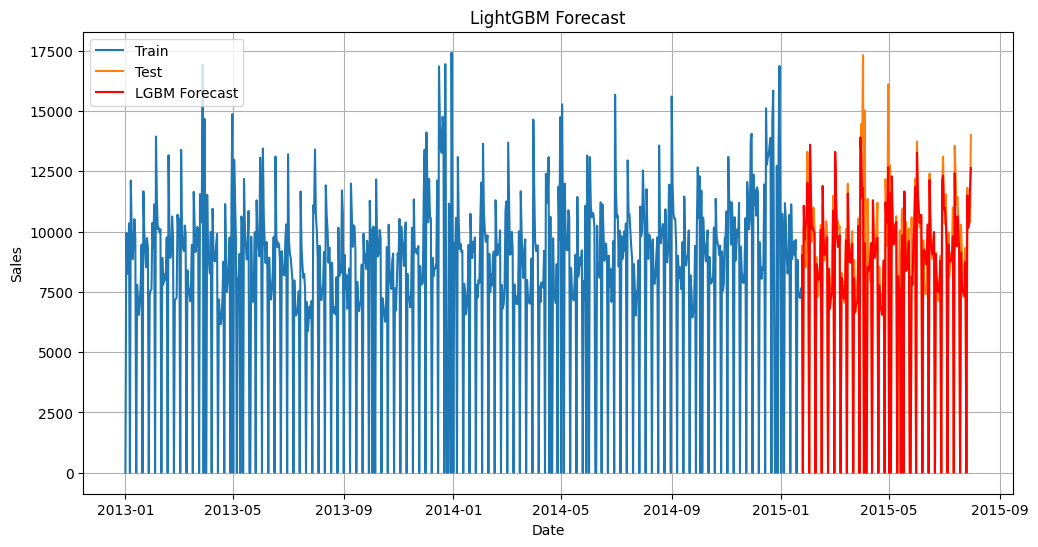

In [23]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data['Sales'], label='Test')
plt.plot(test_data.index, lgbm_test_preds, label='LGBM Forecast', color='red')
plt.title('LightGBM Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

## CatBoost

In [28]:
catboost_model = CatBoostRegressor(random_seed=42, verbose=1000)

In [30]:
catboost_model.fit(train_prep_X, train_prep_Y)

Learning rate set to 0.039148
0:	learn: 3869.4723567	total: 55.3ms	remaining: 55.3s
999:	learn: 343.9188603	total: 833ms	remaining: 0us


In [31]:
# Generate predictions on the training set
catboost_train_preds = catboost_model.predict(train_prep_X)
catboost_train_preds = pd.Series(catboost_train_preds, index=train_prep_X.index)
catboost_train_preds = catboost_train_preds.clip(lower=0)
catboost_train_preds[train_prep_X["Open"] == 0] = 0
print(f'RMSPE for CatBoost on Train: {rmspe(catboost_train_preds, train_prep_Y)}')

RMSPE for CatBoost on Train: 0.03932461455587139


In [33]:
# Generate predictions on the training set
catboost_test_preds = catboost_model.predict(test_prep_X)
catboost_test_preds = pd.Series(catboost_test_preds, index=test_prep_X.index)
catboost_test_preds = catboost_test_preds.clip(lower=0)
catboost_test_preds[test_prep_X["Open"] == 0] = 0
print(f'RMSPE for CatBoost on Test: {rmspe(catboost_test_preds, test_prep_Y)}')

RMSPE for CatBoost on Test: 0.11129573272076719


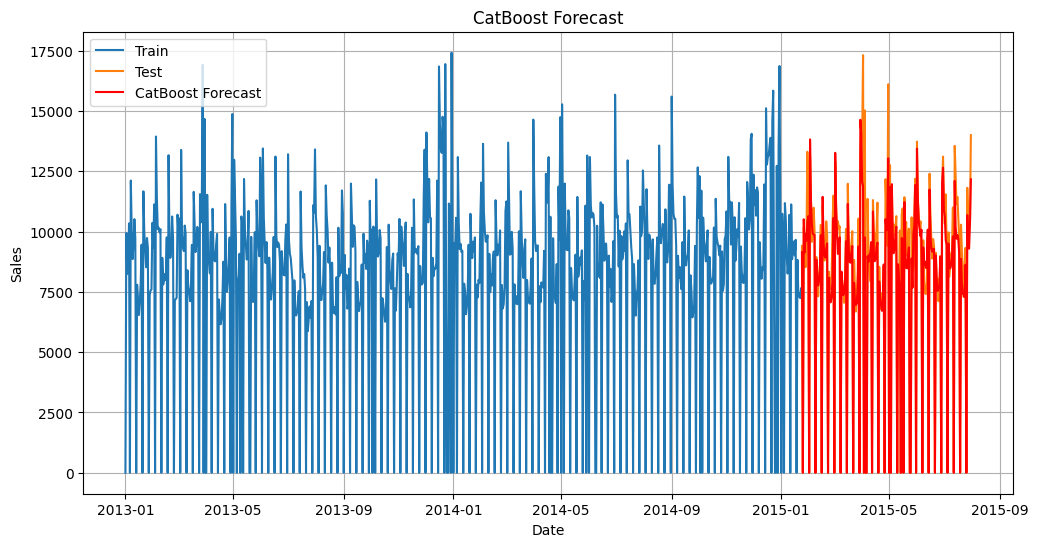

In [41]:
# Plot the results for CatBoost
plt.figure(figsize=(12, 6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data['Sales'], label='Test')
plt.plot(test_data.index, catboost_test_preds, label='CatBoost Forecast', color='red')
plt.title('CatBoost Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

## XGBoost 

In [35]:
xgb_model = xgb.XGBRegressor(random_state=42)

In [37]:
xgb_model.fit(train_prep_X, train_prep_Y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [38]:
# Generate predictions on the training set
xgb_train_preds = xgb_model.predict(train_prep_X)
xgb_train_preds = pd.Series(xgb_train_preds, index=train_prep_X.index)
xgb_train_preds = xgb_train_preds.clip(lower=0)
xgb_train_preds[train_prep_X["Open"] == 0] = 0
print(f'RMSPE for XGBoost on Train: {rmspe(xgb_train_preds, train_prep_Y)}')

RMSPE for XGBoost on Train: 0.009735113676904942


In [39]:
# Generate predictions on the testing set
xgb_test_preds = xgb_model.predict(test_prep_X)
xgb_test_preds = pd.Series(xgb_test_preds, index=test_prep_X.index)
xgb_test_preds = xgb_test_preds.clip(lower=0)
xgb_test_preds[test_prep_X["Open"] == 0] = 0
print(f'RMSPE for XGBoost on Test: {rmspe(xgb_test_preds, test_prep_Y)}')

RMSPE for XGBoost on Test: 0.11984149449805333


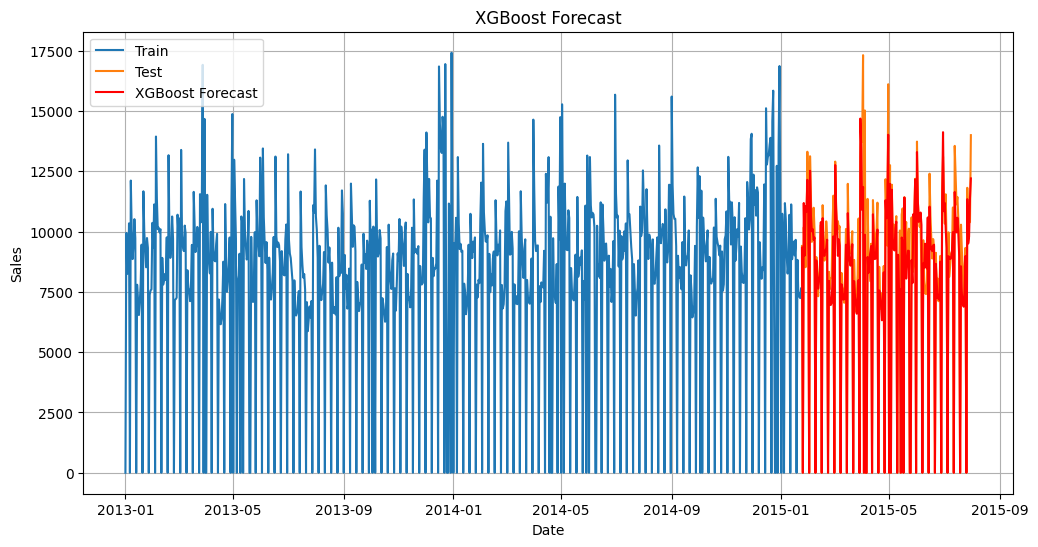

In [42]:
# Plot the results for XGBoost
plt.figure(figsize=(12, 6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data['Sales'], label='Test')
plt.plot(test_data.index, xgb_test_preds, label='XGBoost Forecast', color='red')
plt.title('XGBoost Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Conclusion
| Model        | Training RMSPE | Testing RMSPE |
|--------------|----------------|---------------|
| LightGBM     | 0.0592         | 0.1141        |
| XGBoost      | 0.0097         | 0.1198        |
| <span style="background-color:#FFFF00">CatBoost</span> | <span style="background-color:#FFFF00">0.0393</span> | <span style="background-color:#FFFF00">0.1113</span> |